In [1]:
# import libraries
import numpy as np
import sys
import psi4
from helper_PFCI import PFHamiltonianGenerator
np.set_printoptions(threshold=sys.maxsize)
psi4.core.set_output_file('output.dat', False)
import time
import json
import matplotlib.pyplot as plt
import json
import os

In [2]:
# read data from .npy files for formaldehyde casci(8,8) calculations

# !!! Change this to the correct path on your computer!
npy_folder = "/Users/rmandern/code/SCQED-PCQED/LiH_data/"

# these file names should still be good
E_npy_file = npy_folder + "LiH_r_scan_6311g_fci_Energies.npy"
Mu_npy_file = npy_folder + "LiH_r_scan_6311g_fci_Dipoles.npy"

# store energy eigenvalues in E_array
E_array = np.load(E_npy_file)
# store dipole matrix elements in Mu_array
Mu_array = np.load(Mu_npy_file)

# print their shape so we know how many elements we have
print(np.shape(E_array))
print(np.shape(Mu_array))
# print(E_array)

(500, 25)
(500, 500, 3, 25)


In [3]:
# setup basic arguments to create an instance of the PFHamiltonianGenerator class
mol_str = """
    Li
    H 1 1.4
    symmetry c1
"""


options_dict = {
    "basis": "sto-3g",
    "scf_type": "pk",
    "e_convergence": 1e-10,
    "d_convergence": 1e-10,
}


cavity_free_dict = {
    'omega_value' : 0.12086,
    'lambda_vector' : np.array([0, 0, 0.0]),
    'ci_level' : 'fci',   
    'full_diagonalization' : True,
    'number_of_photons' : 10, 
}

# create the instance of our PFHamiltonianGenerator class
instance = PFHamiltonianGenerator(mol_str, options_dict, cavity_free_dict)


Start SCF iterations:

Canonical RHF One-electron energy = -12.6946346236296037
CQED-RHF One-electron energy      = -12.6946346236296037
Nuclear repulsion energy          = 1.1339511657214287
Dipole energy                     = 0.0000000000000000
SCF Iteration   1: Energy = -7.8605386610570473   dE = -7.86054E+00   dRMS = 1.78805E-13
SCF Iteration   2: Energy = -7.8605386610570385   dE =  8.88178E-15   dRMS = 3.97663E-14
Total time for SCF iterations: 0.000 seconds 

QED-RHF   energy: -7.86053866 hartree
Psi4  SCF energy: -7.86053866 hartree
 Completed QED-RHF in 0.2642362117767334 seconds
 Completed 1HSO Build in 5.793571472167969e-05 seconds
 Completed ERI Build in 0.0012400150299072266 seconds 
 Completed 2D build in 0.00012683868408203125 seconds
 Completed 1G build in 1.52587890625e-05 seconds
 Completed the Dipole Matrix Build in 4.1961669921875e-05 seconds
 Completed determinant list in 0.00045609474182128906 seconds 
 Completed constant offset matrix in 0.00024008750915527344 

In [4]:
N_R = 21

d_array = np.linspace(1.4, 2.2, N_R)
N_l = len(d_array)
N_el = 200
N_ph = 10
omega = 0.12086
lambda_vector = np.array([0, 0, 0.05])

# create an array of zeros to store the PCQED eigenvalues for each value of d
_pcqed_10010_dse = np.zeros((N_l, N_el * N_ph))
# loop over values of d, build Hamiltonian, capture eigenvalues
ctr = 0
for d in d_array:
    instance.fast_build_pcqed_pf_hamiltonian(N_el, N_ph, omega, lambda_vector , E_array[:,ctr], Mu_array[:,:,:,ctr], neglect_DSE=False)      # E_array[:,ctr]: 20 energy values for fisrt displacement and so on... 
    _pcqed_10010_dse[ctr, :] = instance.PCQED_pf_eigs
    ctr += 1

In [5]:
N_R = 21
d_array = np.linspace(1.4, 2.2, N_R)
N_l = len(d_array)
N_el = 200
N_ph = 10
omega = 0.12086
lambda_vector = np.array([0, 0, 0.05])

# create an array of zeros to store the PCQED eigenvalues for each value of d
_pcqed_10010_withoutdse = np.zeros((N_l, N_el * N_ph))
# loop over values of d, build Hamiltonian, capture eigenvalues
ctr = 0
for d in d_array:
    instance.fast_build_pcqed_pf_hamiltonian(N_el, N_ph, omega, lambda_vector ,E_array[:,ctr], Mu_array[:,:,:,ctr], neglect_DSE=True)      # E_array[:,ctr]: 20 energy values for fisrt displacement and so on... 
    _pcqed_10010_withoutdse[ctr, :] = instance.PCQED_pf_eigs
    ctr += 1

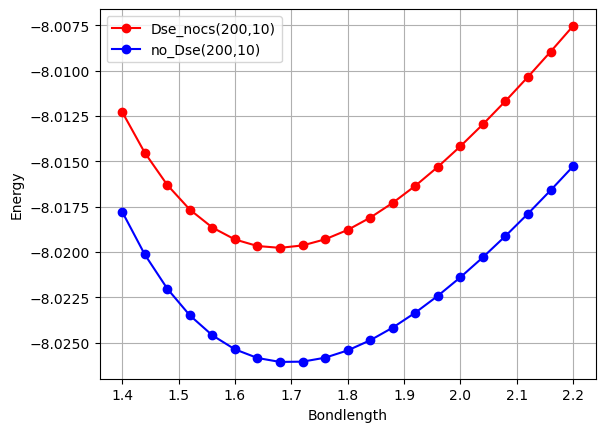

In [6]:
plt.plot(d_array, _pcqed_10010_dse[:,0],'ro-', label="Dse_nocs(200,10)")
# plt.plot(d_array,_pcqed_22_cs[:,0], label='Dse_cs')
plt.plot(d_array,_pcqed_10010_withoutdse[:,0], 'bo-', label='no_Dse(200,10)')
# plt.plot(d_array,_pcqed_22_withoutdse_cs[:,0], label='noDse_cs')

# plt.plot(lambda_val[:,2],_pcqed_502[:,2],'ro-', label='2nd')
# plt.plot(lambda_val[:,2],_pcqed_502[:,3],'b', label='3rd')
# plt.plot(lambda_val[:,2],_pcqed_502[:,4],'y', label='4th')

plt.xlabel('Bondlength')
plt.ylabel('Energy')
# plt.ylim(-0.0003, -0.0001)
plt.grid()
plt.legend()
# plt.savefig('LiH_0.03.png')

In [17]:
# json file name
cs_dir = "/Users/rmandern/code/data_repository/Mapol/LiH/qed_cas/coherent_state_basis/"
new_cs = "/Users/rmandern/code/data_repository/Mapol/LiH/"

pn_dir = "/Users/rmandern/code/data_repository/Mapol/LiH/qed_cas/number_state_basis/"

ref_file = "/Users/rmandern/code/data_repository/Mapol/LiH/qed_fci/bond_stretch_50_points/6311g/coherent_state_basis/LiH_qed-fci_6-311g_coherent_state_basis_10_lambda_0.0_0.0_0.05__singlet_omega_0.12086.json"

new_5v_np1 = new_cs + "LiH_qed-cas_4_5_6-311g_coherent_state_basis_1_lambda_0.0_0.0_0.05_omega_0.12086.json"
new_5v_np10 = new_cs + "LiH_qed-cas_4_5_6-311g_coherent_state_basis_10_lambda_0.0_0.0_0.05_omega_0.12086.json"

new_5v_pnnp1 = new_cs + "LiH_qed-cas_4_5_6-311g_photon_number_basis_1_lambda_0.0_0.0_0.05_omega_0.12086.json"
new_5v_pnnp10 = new_cs + "LiH_qed-cas_4_5_6-311g_photon_number_basis_10_lambda_0.0_0.0_0.05_omega_0.12086.json"

new_df5_np1 = json.load(open(new_5v_np1))
new_df5_np10 = json.load(open(new_5v_np10))
new_df5_pnnp1 = json.load(open(new_5v_pnnp1))
new_df5_pnnp10 = json.load(open(new_5v_pnnp10))

reff1 = open(ref_file)
rdata = json.load(reff1)
ref_data = np.array(rdata["return_result"])
r_data = np.linspace(1.4, 2.2, 50)

new_eig5_np_1 = np.array(new_df5_np1["return_result"])
new_eig5_np_10 = np.array(new_df5_np10["return_result"])
new_eig5_pnnp_1 = np.array(new_df5_pnnp1["return_result"])
new_eig5_pnnp_10 = np.array(new_df5_pnnp10["return_result"])

#npth = "C10H8_number_basis_np_0.json"
#npth_data = json.load(open(npth))

#coords = npth_data["molecule"]["coordinates"]
#print(coords)

In [18]:
# file names with different numbers of virtual orbitals
#fn_2v = cs_dir + "LiH_qed-fci_6-311g_coherent_state_basis_1_4_2_lambda_0.0_0.0_0.05__singlet_omega_0.12086.json"
fn_3v = cs_dir + "LiH_qed-cas_6-311g_coherent_state_basis_1_4_3_lambda_0.0_0.0_0.05__singlet_omega_0.12086.json"
fn_4v = cs_dir + "LiH_qed-cas_6-311g_coherent_state_basis_1_4_4_lambda_0.0_0.0_0.05__singlet_omega_0.12086.json"
fn_5v = cs_dir + "LiH_qed-cas_6-311g_coherent_state_basis_1_4_5_lambda_0.0_0.0_0.05__singlet_omega_0.12086.json"
#fn_6v = cs_dir + "LiH_qed-cas_6-311g_coherent_state_basis_1_4_6_lambda_0.0_0.0_0.05__singlet_omega_0.12086.json"
fn_6v = cs_dir + "LiH_qed-cas_4_6_6-311g_coherent_state_basis_1_lambda_0.0_0.0_0.05_omega_0.12086.json"
fn_7v = cs_dir + "LiH_qed-cas_6-311g_coherent_state_basis_1_4_7_lambda_0.0_0.0_0.05__singlet_omega_0.12086.json"
fn_8v = cs_dir + "LiH_qed-cas_6-311g_coherent_state_basis_1_4_8_lambda_0.0_0.0_0.05__singlet_omega_0.12086.json"
fn_9v = cs_dir + "LiH_qed-cas_6-311g_coherent_state_basis_1_4_9_lambda_0.0_0.0_0.05__singlet_omega_0.12086.json"
fn_10v = cs_dir + "LiH_qed-cas_6-311g_coherent_state_basis_1_4_10_lambda_0.0_0.0_0.05__singlet_omega_0.12086.json"
fn_11v = cs_dir +"LiH_qed-cas_6-311g_coherent_state_basis_1_4_11_lambda_0.0_0.0_0.05__singlet_omega_0.12086.json"
fn_12v = cs_dir + "LiH_qed-cas_6-311g_coherent_state_basis_1_4_12_lambda_0.0_0.0_0.05__singlet_omega_0.12086.json"
fn_13v = cs_dir + "LiH_qed-cas_6-311g_coherent_state_basis_1_4_13_lambda_0.0_0.0_0.05__singlet_omega_0.12086.json"
fn_14v = cs_dir + "LiH_qed-cas_6-311g_coherent_state_basis_1_4_14_lambda_0.0_0.0_0.05__singlet_omega_0.12086.json"
fn_15v = cs_dir + "LiH_qed-cas_6-311g_coherent_state_basis_1_4_15_lambda_0.0_0.0_0.05__singlet_omega_0.12086.json"
fn_16v = cs_dir + "LiH_qed-cas_6-311g_coherent_state_basis_1_4_16_lambda_0.0_0.0_0.05__singlet_omega_0.12086.json"

#pn_2v = pn_dir + "LiH_qed-cas_6-311g_photon_number_basis_1_4_2_lambda_0.0_0.0_0.05__singlet_omega_0.12086.json"
pn_3v = pn_dir + "LiH_qed-cas_6-311g_photon_number_basis_1_4_3_lambda_0.0_0.0_0.05__singlet_omega_0.12086.json"
pn_4v = pn_dir + "LiH_qed-cas_6-311g_photon_number_basis_1_4_4_lambda_0.0_0.0_0.05__singlet_omega_0.12086.json"
pn_5v = pn_dir + "LiH_qed-cas_6-311g_photon_number_basis_1_4_5_lambda_0.0_0.0_0.05__singlet_omega_0.12086.json"
#pn_6v = pn_dir + "LiH_qed-cas_6-311g_photon_number_basis_1_4_6_lambda_0.0_0.0_0.05__singlet_omega_0.12086.json"
pn_6v = pn_dir + "LiH_qed-cas_4_6_6-311g_photon_number_basis_1_lambda_0.0_0.0_0.05_omega_0.12086.json"
pn_7v = pn_dir + "LiH_qed-cas_6-311g_photon_number_basis_1_4_7_lambda_0.0_0.0_0.05__singlet_omega_0.12086.json"
pn_8v = pn_dir + "LiH_qed-cas_6-311g_photon_number_basis_1_4_8_lambda_0.0_0.0_0.05__singlet_omega_0.12086.json"
pn_9v = pn_dir + "LiH_qed-cas_6-311g_photon_number_basis_1_4_9_lambda_0.0_0.0_0.05__singlet_omega_0.12086.json"
pn_10v = pn_dir + "LiH_qed-cas_6-311g_photon_number_basis_1_4_10_lambda_0.0_0.0_0.05__singlet_omega_0.12086.json"
pn_11v = pn_dir + "LiH_qed-cas_6-311g_photon_number_basis_1_4_11_lambda_0.0_0.0_0.05__singlet_omega_0.12086.json"
pn_12v = pn_dir + "LiH_qed-cas_6-311g_photon_number_basis_1_4_12_lambda_0.0_0.0_0.05__singlet_omega_0.12086.json"
pn_13v = pn_dir + "LiH_qed-cas_6-311g_photon_number_basis_1_4_13_lambda_0.0_0.0_0.05__singlet_omega_0.12086.json"
pn_14v = pn_dir + "LiH_qed-cas_6-311g_photon_number_basis_1_4_14_lambda_0.0_0.0_0.05__singlet_omega_0.12086.json"
pn_15v = pn_dir + "LiH_qed-cas_6-311g_photon_number_basis_1_4_15_lambda_0.0_0.0_0.05__singlet_omega_0.12086.json"
pn_16v = pn_dir + "LiH_qed-cas_6-311g_photon_number_basis_1_4_16_lambda_0.0_0.0_0.05__singlet_omega_0.12086.json"

#df2 = json.load(open(fn_2v))
df3 = json.load(open(fn_3v))
df4 = json.load(open(fn_4v))
df5 = json.load(open(fn_5v))
df6 = json.load(open(fn_6v))
df7 = json.load(open(fn_7v))
df8 = json.load(open(fn_8v))
df9 = json.load(open(fn_9v))
df10 = json.load(open(fn_10v))
df11 = json.load(open(fn_11v))
df12 = json.load(open(fn_12v))
df13 = json.load(open(fn_13v))
df14 = json.load(open(fn_14v))
df15 = json.load(open(fn_15v))
df16 = json.load(open(fn_16v))

#pf2 = json.load(open(pn_2v))
pf3 = json.load(open(pn_3v))
pf4 = json.load(open(pn_4v))
pf5 = json.load(open(pn_5v))
pf6 = json.load(open(pn_6v))
pf7 = json.load(open(pn_7v))
pf8 = json.load(open(pn_8v))
pf9 = json.load(open(pn_9v))
pf10 = json.load(open(pn_10v))
pf11 = json.load(open(pn_11v))
pf12 = json.load(open(pn_12v))
pf13 = json.load(open(pn_13v))
pf14 = json.load(open(pn_14v))
pf15 = json.load(open(pn_15v))
pf16 = json.load(open(pn_16v))

#eig2 = np.array(df2["return_result"])
eig3 = np.array(df3["return_result"])
eig4 = np.array(df4["return_result"])
eig5 = np.array(df5["return_result"])
eig6 = np.array(df6["return_result"])
eig7 = np.array(df7["return_result"])
eig8 = np.array(df8["return_result"])
eig9 = np.array(df9["return_result"])
eig10 = np.array(df10["return_result"])
eig11 = np.array(df11["return_result"])
eig12 = np.array(df12["return_result"])
eig13 = np.array(df13["return_result"])
eig14 = np.array(df14["return_result"])
eig15 = np.array(df15["return_result"])
eig16 = np.array(df16["return_result"])


#peig2 = np.array(pf2["return_result"])
peig3 = np.array(pf3["return_result"])
peig4 = np.array(pf4["return_result"])
peig5 = np.array(pf5["return_result"])
peig6 = np.array(pf6["return_result"])
peig7 = np.array(pf7["return_result"])
peig8 = np.array(pf8["return_result"])
peig9 = np.array(pf9["return_result"])
peig10 = np.array(pf10["return_result"])
peig11 = np.array(pf11["return_result"])
peig12 = np.array(pf12["return_result"])
peig13 = np.array(pf13["return_result"])
peig14 = np.array(pf14["return_result"])
peig15 = np.array(pf15["return_result"])
peig16 = np.array(pf16["return_result"])


In [19]:
# file names with different numbers of virtual orbitals
#fn_2v = cs_dir + "LiH_qed-fci_6-311g_coherent_state_basis_1_4_2_lambda_0.0_0.0_0.05__singlet_omega_0.12086.json"
fn_3v10 = cs_dir + "LiH_qed-cas_6-311g_coherent_state_basis_10_4_3_lambda_0.0_0.0_0.05__singlet_omega_0.12086.json"
fn_4v10 = cs_dir + "LiH_qed-cas_6-311g_coherent_state_basis_10_4_4_lambda_0.0_0.0_0.05__singlet_omega_0.12086.json"
fn_5v10 = cs_dir + "LiH_qed-cas_6-311g_coherent_state_basis_10_4_5_lambda_0.0_0.0_0.05__singlet_omega_0.12086.json"
#fn_6v10 = cs_dir + "LiH_qed-cas_6-311g_coherent_state_basis_10_4_6_lambda_0.0_0.0_0.05__singlet_omega_0.12086.json"
fn_6v10 = cs_dir + "LiH_qed-cas_4_6_6-311g_coherent_state_basis_10_lambda_0.0_0.0_0.05_omega_0.12086.json"
fn_7v10 = cs_dir + "LiH_qed-cas_6-311g_coherent_state_basis_10_4_7_lambda_0.0_0.0_0.05__singlet_omega_0.12086.json"
fn_8v10 = cs_dir + "LiH_qed-cas_6-311g_coherent_state_basis_10_4_8_lambda_0.0_0.0_0.05__singlet_omega_0.12086.json"
fn_9v10 = cs_dir + "LiH_qed-cas_6-311g_coherent_state_basis_10_4_9_lambda_0.0_0.0_0.05__singlet_omega_0.12086.json"
fn_10v10 = cs_dir + "LiH_qed-cas_6-311g_coherent_state_basis_10_4_10_lambda_0.0_0.0_0.05__singlet_omega_0.12086.json"
fn_11v10 = cs_dir +"LiH_qed-cas_6-311g_coherent_state_basis_10_4_11_lambda_0.0_0.0_0.05__singlet_omega_0.12086.json"
fn_12v10 = cs_dir + "LiH_qed-cas_6-311g_coherent_state_basis_10_4_12_lambda_0.0_0.0_0.05__singlet_omega_0.12086.json"
fn_13v10 = cs_dir + "LiH_qed-cas_6-311g_coherent_state_basis_10_4_13_lambda_0.0_0.0_0.05__singlet_omega_0.12086.json"
fn_14v10 = cs_dir + "LiH_qed-cas_6-311g_coherent_state_basis_10_4_14_lambda_0.0_0.0_0.05__singlet_omega_0.12086.json"
fn_15v10 = cs_dir + "LiH_qed-cas_6-311g_coherent_state_basis_10_4_15_lambda_0.0_0.0_0.05__singlet_omega_0.12086.json"
fn_16v10 = cs_dir + "LiH_qed-cas_6-311g_coherent_state_basis_10_4_16_lambda_0.0_0.0_0.05__singlet_omega_0.12086.json"

#pn_2v = pn_dir + "LiH_qed-cas_6-311g_photon_number_basis_1_4_2_lambda_0.0_0.0_0.05__singlet_omega_0.12086.json"
pn_3v10 = pn_dir + "LiH_qed-cas_6-311g_photon_number_basis_10_4_3_lambda_0.0_0.0_0.05__singlet_omega_0.12086.json"
pn_4v10 = pn_dir + "LiH_qed-cas_6-311g_photon_number_basis_10_4_4_lambda_0.0_0.0_0.05__singlet_omega_0.12086.json"
pn_5v10 = pn_dir + "LiH_qed-cas_6-311g_photon_number_basis_10_4_5_lambda_0.0_0.0_0.05__singlet_omega_0.12086.json"
#pn_6v10 = pn_dir + "LiH_qed-cas_6-311g_photon_number_basis_10_4_6_lambda_0.0_0.0_0.05__singlet_omega_0.12086.json"
pn_6v10 = pn_dir + "LiH_qed-cas_4_6_6-311g_photon_number_basis_10_lambda_0.0_0.0_0.05_omega_0.12086.json"
pn_7v10 = pn_dir + "LiH_qed-cas_6-311g_photon_number_basis_10_4_7_lambda_0.0_0.0_0.05__singlet_omega_0.12086.json"
pn_8v10 = pn_dir + "LiH_qed-cas_6-311g_photon_number_basis_10_4_8_lambda_0.0_0.0_0.05__singlet_omega_0.12086.json"
pn_9v10 = pn_dir + "LiH_qed-cas_6-311g_photon_number_basis_10_4_9_lambda_0.0_0.0_0.05__singlet_omega_0.12086.json"
pn_10v10 = pn_dir + "LiH_qed-cas_6-311g_photon_number_basis_10_4_10_lambda_0.0_0.0_0.05__singlet_omega_0.12086.json"
pn_11v10 = pn_dir + "LiH_qed-cas_6-311g_photon_number_basis_10_4_11_lambda_0.0_0.0_0.05__singlet_omega_0.12086.json"
pn_12v10 = pn_dir + "LiH_qed-cas_6-311g_photon_number_basis_10_4_12_lambda_0.0_0.0_0.05__singlet_omega_0.12086.json"
pn_13v10 = pn_dir + "LiH_qed-cas_6-311g_photon_number_basis_10_4_13_lambda_0.0_0.0_0.05__singlet_omega_0.12086.json"
pn_14v10 = pn_dir + "LiH_qed-cas_6-311g_photon_number_basis_10_4_14_lambda_0.0_0.0_0.05__singlet_omega_0.12086.json"
pn_15v10 = pn_dir + "LiH_qed-cas_6-311g_photon_number_basis_10_4_15_lambda_0.0_0.0_0.05__singlet_omega_0.12086.json"
pn_16v10 = pn_dir + "LiH_qed-cas_6-311g_photon_number_basis_10_4_16_lambda_0.0_0.0_0.05__singlet_omega_0.12086.json"

#df2 = json.load(open(fn_2v))
df310 = json.load(open(fn_3v10))
df410 = json.load(open(fn_4v10))
df510 = json.load(open(fn_5v10))
df610 = json.load(open(fn_6v10))
df710 = json.load(open(fn_7v10))
df810 = json.load(open(fn_8v10))
df910 = json.load(open(fn_9v10))
df1010 = json.load(open(fn_10v10))
df1110 = json.load(open(fn_11v10))
df1210 = json.load(open(fn_12v10))
df1310 = json.load(open(fn_13v10))
df1410 = json.load(open(fn_14v10))
df1510 = json.load(open(fn_15v10))
df1610 = json.load(open(fn_16v10))

#pf2 = json.load(open(pn_2v))
pf310 = json.load(open(pn_3v10))
pf410 = json.load(open(pn_4v10))
pf510 = json.load(open(pn_5v10))
pf610 = json.load(open(pn_6v10))
pf710 = json.load(open(pn_7v10))
pf810 = json.load(open(pn_8v10))
pf910 = json.load(open(pn_9v10))
pf1010 = json.load(open(pn_10v10))
pf1110 = json.load(open(pn_11v10))
pf1210 = json.load(open(pn_12v10))
pf1310 = json.load(open(pn_13v10))
pf1410 = json.load(open(pn_14v10))
pf1510 = json.load(open(pn_15v10))
pf1610 = json.load(open(pn_16v10))

#eig2 = np.array(df2["return_result"])
eig310 = np.array(df310["return_result"])
eig410 = np.array(df410["return_result"])
eig510 = np.array(df510["return_result"])
eig610 = np.array(df610["return_result"])
eig710 = np.array(df710["return_result"])
eig810 = np.array(df810["return_result"])
eig910 = np.array(df910["return_result"])
eig1010 = np.array(df1010["return_result"])
eig1110 = np.array(df1110["return_result"])
eig1210 = np.array(df1210["return_result"])
eig1310 = np.array(df1310["return_result"])
eig1410 = np.array(df1410["return_result"])
eig1510 = np.array(df1510["return_result"])
eig1610 = np.array(df1610["return_result"])


#peig2 = np.array(pf2["return_result"])
peig310 = np.array(pf310["return_result"])
peig410 = np.array(pf410["return_result"])
peig510 = np.array(pf510["return_result"])
peig610 = np.array(pf610["return_result"])
peig710 = np.array(pf710["return_result"])
peig810 = np.array(pf810["return_result"])
peig910 = np.array(pf910["return_result"])
peig1010 = np.array(pf1010["return_result"])
peig1110 = np.array(pf1110["return_result"])
peig1210 = np.array(pf1210["return_result"])
peig1310 = np.array(pf1310["return_result"])
peig1410 = np.array(pf1410["return_result"])
peig1510 = np.array(pf1510["return_result"])
peig1610 = np.array(pf1610["return_result"])


In [20]:
np.allclose(new_eig5_pnnp_10, peig510)

True

In [21]:
def mae(array, reference):
    diff = np.abs(array - reference)
    mae = np.mean(diff)
    mx = np.max(diff)
    mn = np.min(diff)
    
    return mx-mn
    #return mae

In [22]:
cs_mae = np.zeros(14)
np_mae = np.zeros(14)
numph = np.linspace(3, 16, 14, dtype=int)
cs_mae10 = np.zeros(14)
np_mae10 = np.zeros(14)

print(numph)
#new_eig5_np_1 = np.array(new_df5_np1["return_result"])
#new_eig5_np_10 = np.array(new_df5_np10["return_result"])
#new_eig5_pnnp_1 = np.array(new_df5_pnnp1["return_result"])
#new_eig5_pnnp_10 = np.array(new_df5_pnnp10["return_result"])

[ 3  4  5  6  7  8  9 10 11 12 13 14 15 16]


In [23]:
cs_mae10[0] = mae(eig310[:,0], ref_data[:,0])
cs_mae10[1] = mae(eig410[:,0], ref_data[:,0])
cs_mae10[2] = mae(eig510[:,0], ref_data[:,0])
cs_mae10[3] = mae(eig610[:,0], ref_data[:,0])
cs_mae10[4] = mae(eig710[:,0], ref_data[:,0])
cs_mae10[5] = mae(eig810[:,0], ref_data[:,0])
cs_mae10[6] = mae(eig910[:,0], ref_data[:,0])
cs_mae10[7] = mae(eig1010[:,0], ref_data[:,0])
cs_mae10[8] = mae(eig1110[:,0], ref_data[:,0])
cs_mae10[9] = mae(eig1210[:,0], ref_data[:,0])
cs_mae10[10] = mae(eig1310[:,0], ref_data[:,0])
cs_mae10[11] = mae(eig1410[:,0], ref_data[:,0])
cs_mae10[12] = mae(eig1510[:,0], ref_data[:,0])
cs_mae10[13] = mae(eig1610[:,0], ref_data[:,0])

np_mae10[0] = mae(peig310[:,0], ref_data[:,0])
np_mae10[1] = mae(peig410[:,0], ref_data[:,0])
np_mae10[2] = mae(peig510[:,0], ref_data[:,0])
np_mae10[3] = mae(peig610[:,0], ref_data[:,0])
np_mae10[4] = mae(peig710[:,0], ref_data[:,0])
np_mae10[5] = mae(peig810[:,0], ref_data[:,0])
np_mae10[6] = mae(peig910[:,0], ref_data[:,0])
np_mae10[7] = mae(peig1010[:,0], ref_data[:,0])
np_mae10[8] = mae(peig1110[:,0], ref_data[:,0])
np_mae10[9] = mae(peig1210[:,0], ref_data[:,0])
np_mae10[10] = mae(peig1310[:,0], ref_data[:,0])
np_mae10[11] = mae(peig1410[:,0], ref_data[:,0])
np_mae10[12] = mae(peig1510[:,0], ref_data[:,0])
np_mae10[13] = mae(peig1610[:,0], ref_data[:,0])

In [24]:
cs_mae[0] = mae(eig3[:,0], ref_data[:,0])
cs_mae[1] = mae(eig4[:,0], ref_data[:,0])
cs_mae[2] = mae(eig5[:,0], ref_data[:,0])
cs_mae[3] = mae(eig6[:,0], ref_data[:,0])
cs_mae[4] = mae(eig7[:,0], ref_data[:,0])
cs_mae[5] = mae(eig8[:,0], ref_data[:,0])
cs_mae[6] = mae(eig9[:,0], ref_data[:,0])
cs_mae[7] = mae(eig10[:,0], ref_data[:,0])
cs_mae[8] = mae(eig11[:,0], ref_data[:,0])
cs_mae[9] = mae(eig12[:,0], ref_data[:,0])
cs_mae[10] = mae(eig13[:,0], ref_data[:,0])
cs_mae[11] = mae(eig14[:,0], ref_data[:,0])
cs_mae[12] = mae(eig15[:,0], ref_data[:,0])
cs_mae[13] = mae(eig16[:,0], ref_data[:,0])

np_mae[0] = mae(peig3[:,0], ref_data[:,0])
np_mae[1] = mae(peig4[:,0], ref_data[:,0])
np_mae[2] = mae(peig5[:,0], ref_data[:,0])
np_mae[3] = mae(peig6[:,0], ref_data[:,0])
np_mae[4] = mae(peig7[:,0], ref_data[:,0])
np_mae[5] = mae(peig8[:,0], ref_data[:,0])
np_mae[6] = mae(peig9[:,0], ref_data[:,0])
np_mae[7] = mae(peig10[:,0], ref_data[:,0])
np_mae[8] = mae(eig11[:,0], ref_data[:,0])
np_mae[9] = mae(eig12[:,0], ref_data[:,0])
np_mae[10] = mae(eig13[:,0], ref_data[:,0])
np_mae[11] = mae(eig14[:,0], ref_data[:,0])
np_mae[12] = mae(eig15[:,0], ref_data[:,0])
np_mae[13] = mae(eig16[:,0], ref_data[:,0])


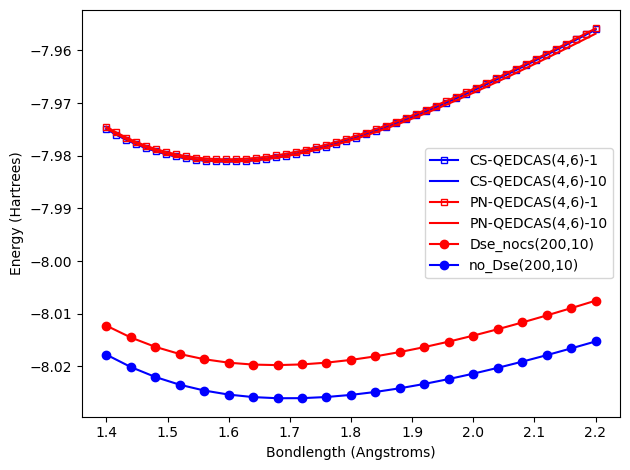

CS-1: Max diff 0.04127546141089411, Min diff 0.034250809955119976, NPE 0.0070246514557741335
CS-10: Max diff 0.04116237250826149, Min diff 0.03423183766800175, NPE 0.006930534840259739
PN-1: Max diff 0.04138716984582391, Min diff 0.03465643761055581, NPE 0.0067307322352681
PN-10: Max diff 0.04039978585732129, Min diff 0.03436459805984704, NPE 0.006035187797474251
0.0067307322352681 0.006035187797474251 0.0070246514557741335 0.006930534840259739


In [25]:
from matplotlib import pyplot as plt
from matplotlib import cm
from matplotlib import rcParams
plt.plot(r_data, eig6[:,0], "blue", marker="s", ms="5", mfc="none", label='CS-QEDCAS(4,6)-1')
plt.plot(r_data, eig610[:,0],  'blue',label='CS-QEDCAS(4,6)-10')
plt.plot(r_data, peig6[:,0], 'red', marker="s", ms="5", mfc="none", label='PN-QEDCAS(4,6)-1')
plt.plot(r_data, peig610[:,0], 'red', label='PN-QEDCAS(4,6)-10')

plt.plot(d_array, _pcqed_10010_dse[:,0],'ro-', label="Dse_nocs(200,10)")
plt.plot(d_array,_pcqed_10010_withoutdse[:,0], 'bo-', label='no_Dse(200,10)')

plt.xlabel("Bondlength (Angstroms)")
plt.ylabel("Energy (Hartrees)")
# plt.xlim(1.4, 2.0)
# plt.ylim(-7.982, -7.965)
plt.legend()
plt.tight_layout()
plt.savefig("LiH_46_xzoom_with_PCQED_200_0.05.png", dpi=150)
plt.show()



diff_cs_1 = eig6[:,0]-ref_data[:,0]
max_cs_1 = max(diff_cs_1)
min_cs_1 = min(diff_cs_1)
print(F'CS-1: Max diff {max_cs_1}, Min diff {min_cs_1}, NPE {max_cs_1 - min_cs_1}')


diff_cs_10 = eig610[:,0]-ref_data[:,0]
max_cs_10 = max(diff_cs_10)
min_cs_10 = min(diff_cs_10)
print(F'CS-10: Max diff {max_cs_10}, Min diff {min_cs_10}, NPE {max_cs_10 - min_cs_10}')

diff_pn_1 = peig6[:,0]-ref_data[:,0]
max_pn_1 = max(diff_pn_1)
min_pn_1 = min(diff_pn_1)
print(F'PN-1: Max diff {max_pn_1}, Min diff {min_pn_1}, NPE {max_pn_1 - min_pn_1}')

diff_pn_10 = peig610[:,0]-ref_data[:,0]
max_pn_10 = max(diff_pn_10)
min_pn_10 = min(diff_pn_10)
print(F'PN-10: Max diff {max_pn_10}, Min diff {min_pn_10}, NPE {max_pn_10 - min_pn_10}')


print(np_mae[3], np_mae10[3], cs_mae[3], cs_mae10[3])